# Simulating Neurons as Poisson Processes

## 1 Preparation

Import the modules required for this session

In [1]:
import quantities as pq
import numpy as np
from matplotlib import pyplot as plt
from elephant.spike_train_generation import StationaryPoissonProcess, NonStationaryPoissonProcess
from elephant.statistics import isi

%matplotlib inline

Define the functions required for this session.

In [2]:
from scipy.stats import poisson, expon
from scipy import interpolate
from neo.core import AnalogSignal


class utils:
    @staticmethod
    def plot_poisson_distribution(rate, duration, x_range):
        bins = np.arange(x_range[0], x_range[1] + 1)
        mu = rate * duration
        prob = poisson.pmf(k=bins, mu=mu)
        plt.plot(bins, prob, color="black", marker="o", linestyle="None")

        f = interpolate.interp1d(bins, prob, kind="cubic")
        bins = np.arange(x_range[0], x_range[1], 0.1)

        plt.plot(bins, f(bins), color="black")
        plt.xlabel("Number of Spikes")
        plt.ylabel("Probability")

    @staticmethod
    def plot_exponential_distribution(rate, x_range):
        t = np.linspace(x_range[0], x_range[1], 1000)
        pdf_values = expon.pdf(t, scale=1 / rate)
        plt.plot(t, pdf_values, color="black")

    @staticmethod
    def NonStationaryPoissonProcess(
        rate, t_stop, burst_rate, burst_start=1 * pq.s, burst_dur=0.2 * pq.s
    ):
        t = np.linspace(0 * pq.s, t_stop, int(t_stop.magnitude * 1000))
        rate_signal = np.zeros(len(t)) * pq.Hz + rate
        idx_start = np.argmin(np.abs(t - burst_start))
        idx_stop = np.argmin(np.abs(t - (burst_start + burst_dur)))
        rate_signal[idx_start:idx_stop] = burst_rate
        rate_signal = AnalogSignal(rate_signal, sampling_rate=1000 * pq.Hz)
        neuron = NonStationaryPoissonProcess(rate_signal)
        return neuron

## 2 Working With Physical Quantities

In Research, we work with many physical quantities (e.g. voltage,
frequency or time) and we use them at different orders of magnitude
(e.g. seconds and milliseconds). This can make it difficult to keep
track of a variable’s unit when we are combining and manipulating
different quantities in our analysis. The `quantities` module addresses
this problem by allowing us to attach physical units to our variables.
When we combine variables with units, quantities will automatically
perform the correct conversion or raise an error if we are trying to
combine incompatible quantities.

| Code | Description |
|------------------------------------|------------------------------------|
| `freq = 2 * pq.Hz` | Define a quantity of 2 Hertz and assign it to the variable `freq` |
| `time = 2500 * pq.ms` | Define a quantity of 2500 milliseconds and assign it to the variable `time` |
| `time.units` | Get the unit of `time` |
| `time.magnitude` | Get the magnitude of `time` |

------------------------------------------------------------------------

<span class="theorem-title">**Exercise 1**</span> Create a variable
called `firing_rate` and assign it the value `5 * pq.Hz`.

*Solution.*

In [3]:
firing_rate = 5 * pq.Hz

<span class="theorem-title">**Exercise 2**</span> Create a variable
called `t_start` and assign it the value `100*pq.ms`.

*Solution.*

In [5]:
t_start = 100 * pq.ms

<span class="theorem-title">**Exercise 3**</span> Create a variable
called `t_stop` and assign it the value `3 * pq.s`

*Solution.*

In [7]:
t_stop = 3 * pq.s

<span class="theorem-title">**Exercise 4**</span> Compute the difference
between `t_stop` and `t_start` and assign the result to a new variable
`duration`. Then, print that variable.

*Solution.*

In [9]:
duration = t_stop - t_start
duration

array(2.9) * s

<span class="theorem-title">**Exercise 5**</span> Get the `.magnitude`
and the `.units` of `duration`.

*Solution.*

In [11]:
duration.units, duration.magnitude

(array(1.) * s, array(2.9))

<span class="theorem-title">**Exercise 6**</span> Try adding the
variables `firing_rate` and `duration`. What error message do you
observe?

*Solution.*

In [13]:
firing_rate+duration

<span class="theorem-title">**Exercise 7**</span> Multiply `firing_rate`
by `duration` and assign the result to a new variable `n_spikes`. Print
that variable.

*Solution.*

In [15]:
n_spikes = firing_rate * duration
n_spikes

array(14.5) * s*Hz

## 3 Simulating Randomly Firing Neurons with Poisson Processes

Simulations are a great for testing data processing and analysis
pipelines because they allow us to compare our results against a known
ground truth. The `elephant` package provides a
`StationaryPoissonProcess` class that simulates spiking events that
occur at a constant average rate and independently of the time since the
last event. A Poisson process has two parameters: the average rate of
events and duration. In this section, we will explore how to generate
spiketrains from Poisson neurons and how to compare the observed event
counts against the theoretical Poisson distribution that describes the
expected number of events.

| Code | Description |
|------------------------------------|------------------------------------|
| `neuron = StationaryPoissonProcess(rate, t_stop=1*pq.s)` | Simulate a Poisson `neuron` with an average firing `rate` that is active from 0 to `1` seconds |
| `st = neuron.generate_spiketrain()` | Generate a spiketrain `st` from the simulated `neuron` |
| `st.times` | Access the `.times` of the generated spikes in the spike train `st` |
| `sts = neuron.generate_n_spiketrains(n)` | Generate a list `sts` with `n` spiketrains from the simulated `neuron` |
| `[st.times for st in sts]` | Get the spike times for every spike train `st` in the list `sts` |
| `ax1 = plt.subplot(2, 1, 1)` | Generate the 1st plot in a 2-by-1 subplot and assign the returned object to a variable `ax1` |
| `plt.subplot(2, 1, 2, sharex=ax1)` | Generate the 2nd plot in a 2-by-1 subplot and make it share the x-axis with `ax1` |
| `plt.eventplot(st.times)` | Create a raster plot of the spike times `st.times` |
| `plt.eventplot([st.times for st in sts])` | Create a raster plot with each spike train in the list of spike trains `sts` |
| `plt.hist(x, density=True)` | Plot the densities of the values in `x` as a histogram |

------------------------------------------------------------------------

<span class="theorem-title">**Example 1**</span> Simulate a neuron as a
`StationaryPoissonProcess` with a `rate=5*pq.Hz` and `t_stop=10*pq.s`.
Then, generate a spike train `st` and print its length (i.e. the number
of spikes).

In [17]:
neuron = StationaryPoissonProcess(rate=5 * pq.Hz, t_stop=10 * pq.s)
st = neuron.generate_spiketrain()
len(st)

57

<span class="theorem-title">**Example 2**</span> Print the spike times
`st.times` with `plt.eventplot`.

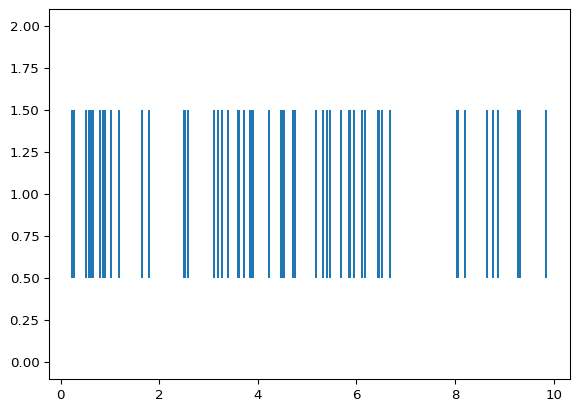

In [18]:
plt.eventplot(st.times)

<span class="theorem-title">**Exercise 8**</span> Simulate a neuron as a
`StationaryPoissonProcess` with a `rate=1*pq.Hz` and `t_stop=10*pq.s`.
Then, generate a spike train `st` and print its length (i.e. the number
of spikes).

*Solution.*

In [19]:
neuron = StationaryPoissonProcess(rate=1 * pq.Hz, t_stop=10 * pq.s)
st = neuron.generate_spiketrain()
len(st)

7

<span class="theorem-title">**Exercise 9**</span> Print the spike times
`st.times` with `plt.eventplot`.

*Solution.*

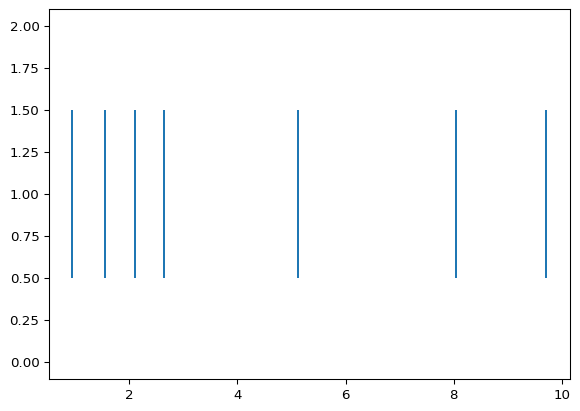

In [21]:
plt.eventplot(st.times)

<span class="theorem-title">**Exercise 10**</span> Simulate a neuron as
a `StationaryPoissonProcess` with a `rate=0.1*pq.Hz` and
`t_stop=2*pq.s`. Then, generate a spike train `st` and plot it with
`plt.eventplot`. Did you see any spikes?

*Solution.*

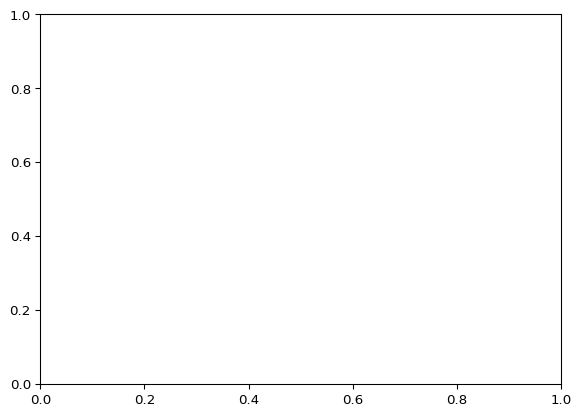

In [23]:
neuron = StationaryPoissonProcess(rate=0.1 * pq.Hz, t_stop=2 * pq.s)
st = neuron.generate_spiketrain()
plt.eventplot(st.times)

<span class="theorem-title">**Example 3**</span> Generate `100` spike
trains from the neuron, then get the times `st.times` for every spike
train `st` in the list of spike trains `sts`.

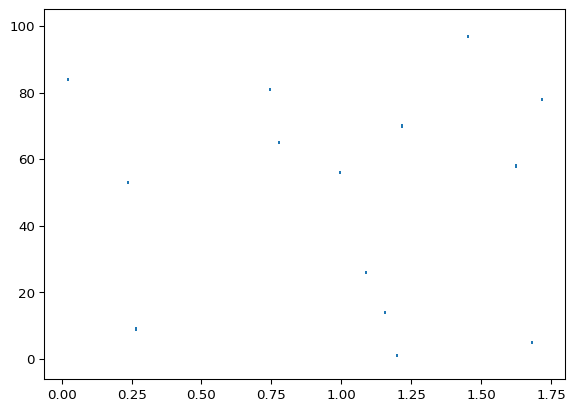

In [25]:
sts = neuron.generate_n_spiketrains(100)
plt.eventplot([st.times for st in sts]);

<span class="theorem-title">**Exercise 11**</span> Generate `500` spike
trains from the neuron, then get the times `st.times` for every spike
train `st` in the list of spike trains `sts`.

*Solution.*

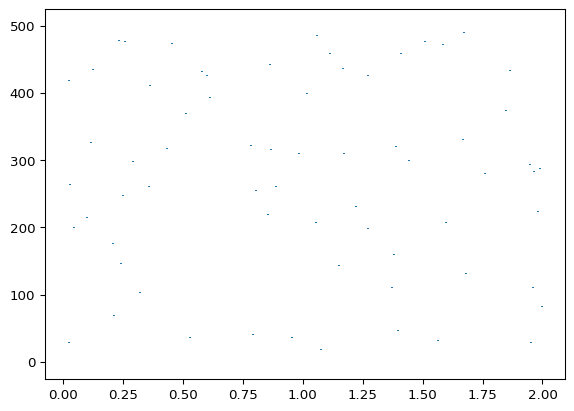

In [26]:
sts = neuron.generate_n_spiketrains(500)
plt.eventplot([st.times for st in sts]);

<span class="theorem-title">**Example 4**</span> Generate `10`
spiketrains from a `neuron` with `rate=1*pq.Hz` and `t_stop=10*pq.s`.
Then, get the number of spikes `n_spikes` from every spike train `st` in
the list of spike trains `sts` and plot their `density` as a histogram.

(array([0.11111111, 0.22222222, 0.        , 0.11111111, 0.        ,
        0.        , 0.        , 0.22222222, 0.33333333, 0.11111111]),
 array([ 5. ,  5.9,  6.8,  7.7,  8.6,  9.5, 10.4, 11.3, 12.2, 13.1, 14. ]),
 <BarContainer object of 10 artists>)

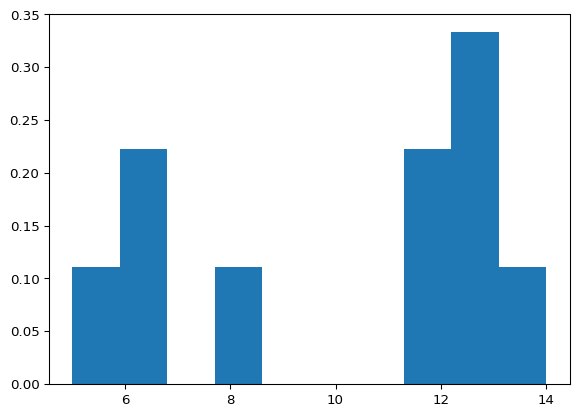

In [28]:
neuron = StationaryPoissonProcess(rate=1*pq.Hz, t_stop=10*pq.s)
sts = neuron.generate_n_spiketrains(10)
n_spikes = [len(st) for st in sts]
plt.hist(n_spikes, density=True)

<span class="theorem-title">**Exercise 12**</span> Generate `100` spike
trains from the same `neuron`, get the number of spikes in every spike
train and plot their density as a histogram.

*Solution.*

(array([0.02      , 0.04666667, 0.16666667, 0.08      , 0.17333333,
        0.08666667, 0.04      , 0.02      , 0.02666667, 0.00666667]),
 array([ 4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. , 17.5, 19. ]),
 <BarContainer object of 10 artists>)

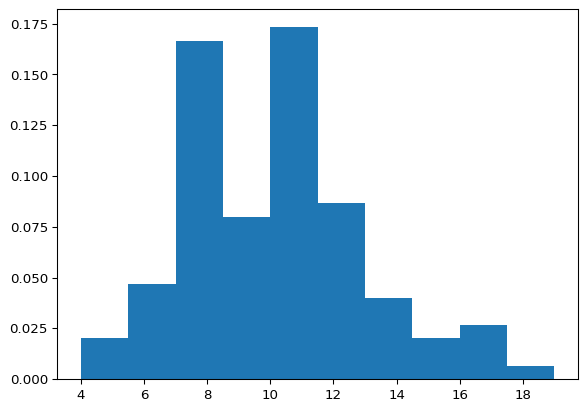

In [29]:
sts = neuron.generate_n_spiketrains(100)
n_spikes = [len(st) for st in sts]
plt.hist(n_spikes, density=True)

<span class="theorem-title">**Exercise 13**</span> Generate `100` spike
trains from the same `neuron`, get the number of spikes in every spike
train and plot their density as a histogram.

*Solution.*

(array([0.00052632, 0.01736842, 0.05526316, 0.10263158, 0.13421053,
        0.11736842, 0.05684211, 0.02578947, 0.01315789, 0.00315789]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

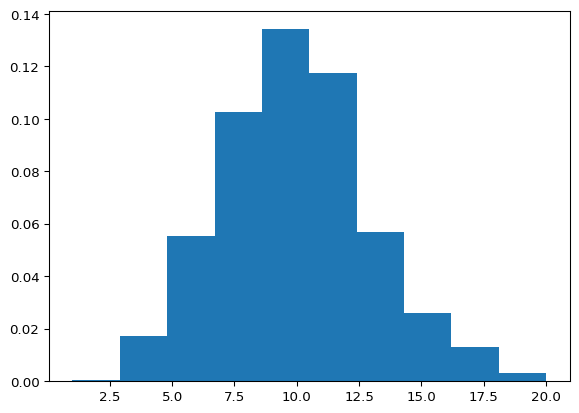

In [31]:
sts = neuron.generate_n_spiketrains(1000)
n_spikes = [len(st) for st in sts]
plt.hist(n_spikes, density=True)

<span class="theorem-title">**Example 5**</span> Plot a histogram with
the density of the observed number of spikes together with the
theoretical Poisson distribution for a neuron with the given `rate` and
`duration`.

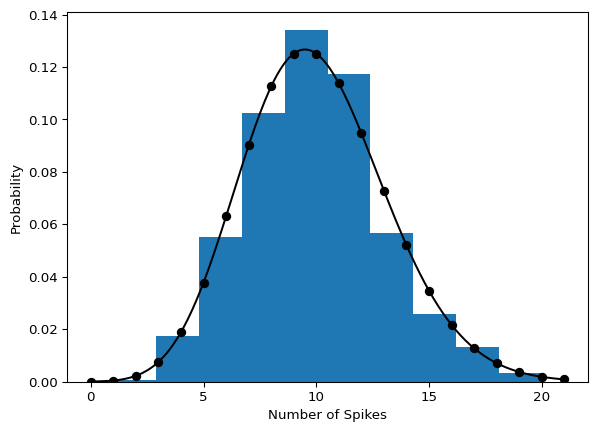

In [33]:
plt.hist(n_spikes, density=True)
utils.plot_poisson_distribution(
    rate=neuron.rate, duration=neuron.t_stop, x_range=(min(n_spikes)-1, max(n_spikes)+1)
)

<span class="theorem-title">**Exercise 14**</span> Generate `100` spike
trains from a `StationaryPoissonProcess` with a `rate=10*pq.Hz` and
`t_stop=20*pq.s`. Then, get the number of spikes for each spike train
and plot a histogram with their density together with the theoretical
Poisson distribution for a neuron with the given `rate` and `duration`.

*Solution.*

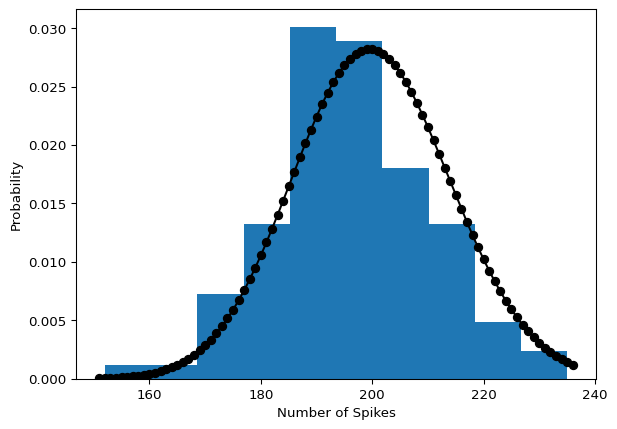

In [34]:
neuron = StationaryPoissonProcess(rate=10 * pq.Hz, t_stop=20 * pq.s)
sts = neuron.generate_n_spiketrains(100)
n_spikes = [len(st) for st in sts]
plt.hist(n_spikes, density=True)
utils.plot_poisson_distribution(
    rate=neuron.rate,
    duration=neuron.t_stop,
    x_range=(min(n_spikes) - 1, max(n_spikes) + 1),
)

<span class="theorem-title">**Exercise 15**</span> Generate `100` spike
trains from a `StationaryPoissonProcess` with a `rate=0.1*pq.Hz` and
`t_stop=20*pq.s`, get the number of spikes for each spike train and plot
a histogram with their density together with the theoretical Poisson
distribution.

*Solution.*

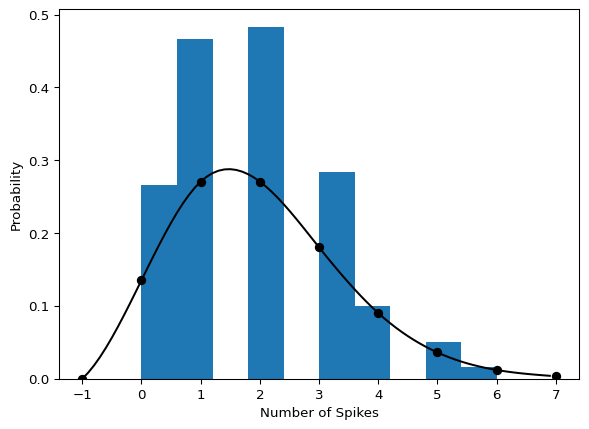

In [36]:
neuron = StationaryPoissonProcess(rate=0.1 * pq.Hz, t_stop=20 * pq.s)
sts = neuron.generate_n_spiketrains(100)
n_spikes = [len(st) for st in sts]
plt.hist(n_spikes, density=True)
utils.plot_poisson_distribution(
    rate=neuron.rate,
    duration=neuron.t_stop,
    x_range=(min(n_spikes) - 1, max(n_spikes) + 1),
)

<span class="theorem-title">**Exercise 16**</span> Generate `1000` spike
trains from the same neuron, get the number of spikes for every spike
train and plot a histogram with their density together with the
theoretical poisson distribution.

*Solution.*

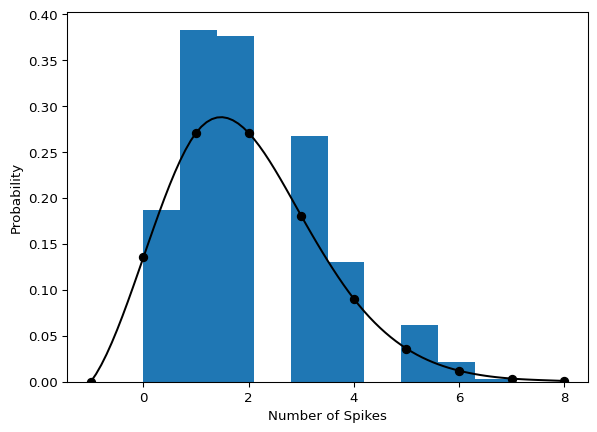

In [38]:
neuron = StationaryPoissonProcess(rate=0.1 * pq.Hz, t_stop=20 * pq.s)
sts = neuron.generate_n_spiketrains(1000)
n_spikes = [len(st) for st in sts]
plt.hist(n_spikes, density=True)
utils.plot_poisson_distribution(
    rate=neuron.rate,
    duration=neuron.t_stop,
    x_range=(min(n_spikes) - 1, max(n_spikes) + 1),
)

## 4 Simulating Bursting Neurons with Non-Stationary Poisson Processes

While the Poisson process allows us to simulate randomly spiking
neurons, in many situations, we want to simulate neurons that respond to
some particular event. This can be done using a non-stationary Process
which works just like the regular poisson Process, except that its rate
varies across time. By setting the time varying rate, we can simulate
neurons that respond with bursting at specific points in time.

| Code | Description |
|------------------------------------|------------------------------------|
| `neuron = utils.NonStationaryPoissonProcess(rate, t_start, burst_rate)` | Simulate a neuron that increases its `rate` to a given `burst_rate` |
| `neuron = utils.NonStationaryPoissonProcess(rate, t_start, burst_rate, burst_start, burst_dur)` | Simulate a neuron that increases its `rate` to a given `burst_rate` at the given `burst_start` for the `burst_dur` |
| `neuron.rate_signal` | Access the time-varying `.rate_signal` of the simulated `neuron` |
| `neuron.rate_signal.times` | Access the time points of the simulated neurons’ `.rate_signal` |

------------------------------------------------------------------------

<span class="theorem-title">**Example 6**</span> Use
`utils.NonStationaryPoissonProcess()` with `rate =5*pq.Hz`,
`t_stop=2*pq.s` and `burst_rate=100*pq.Hz` to simulate a `neuron` and
plot its `rate_signal`.

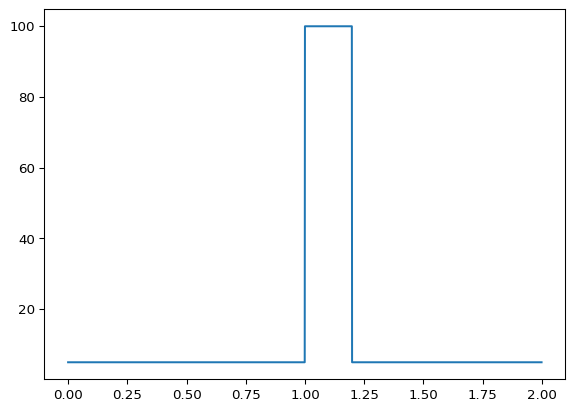

In [40]:
neuron = utils.NonStationaryPoissonProcess(
    rate=5 * pq.Hz,
    t_stop=2 * pq.s,
    burst_rate=100 * pq.Hz,
)
plt.plot(neuron.rate_signal.times, neuron.rate_signal)

<span class="theorem-title">**Example 7**</span> Generate a spiketrain
from the `neuron`. Then, plot the neurons `.rate_signal` together with
the spike times `st` in a 2-by-1 subplot grid with a shared x-axis.

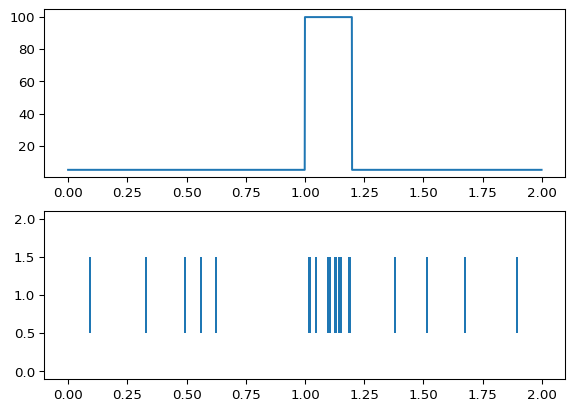

In [41]:
st = neuron.generate_spiketrain()
ax1 = plt.subplot(2, 1, 1)
plt.plot(neuron.rate_signal.times, neuron.rate_signal)
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.eventplot(st.times)

<span class="theorem-title">**Exercise 17**</span> Use
`utils.NonStationaryPoissonProcess` with `rate=15*pq.Hz`,
`t_stop=2*pq.s` and `burst_rate=30*pq.Hz` to simulate a `neuron` and
plot its `.rate_signal`.

*Solution.*

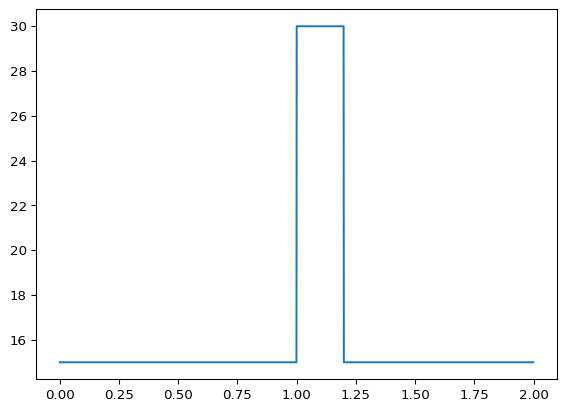

In [42]:
neuron = utils.NonStationaryPoissonProcess(
    rate=15 * pq.Hz,
    t_stop=2 * pq.s,
    burst_rate=30 * pq.Hz,
)
plt.plot(neuron.rate_signal.times, neuron.rate_signal)

<span class="theorem-title">**Exercise 18**</span> Generate a spiketrain
from the `neuron`. Then, plot the neurons `.rate_signal` together with
the spike times `st` in a 2-by-1 subplot grid with a shared x-axis.

*Solution.*

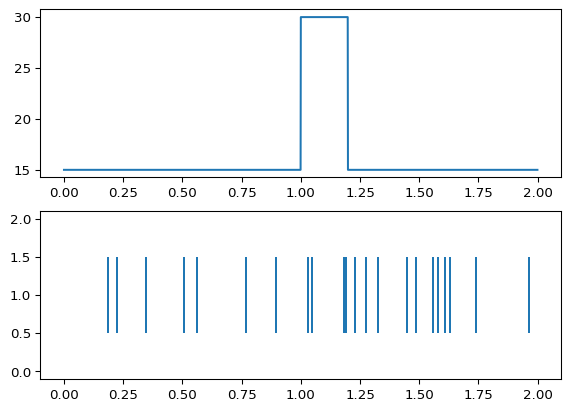

In [44]:
st = neuron.generate_spiketrain()
ax1 = plt.subplot(2, 1, 1)
plt.plot(neuron.rate_signal.times, neuron.rate_signal)
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.eventplot(st.times)

<span class="theorem-title">**Exercise 19**</span> Use
`utils.NonStationaryPoissonProcess` with the arguments
`burst_start=1.2*pq.s` and `burst_dur=0.5*pq.s`. Then, generate a
spiketrain from the `neuron` and plot the neurons `.rate_signal`
together with the spike times `st` in a 2-by-1 subplot grid with a
shared x-axis.

*Solution.*

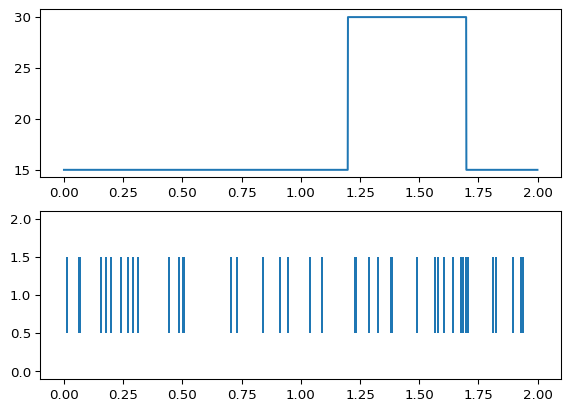

In [46]:
neuron = utils.NonStationaryPoissonProcess(
    rate=15 * pq.Hz,
    t_stop=2 * pq.s,
    burst_rate=30 * pq.Hz,
    burst_start=1.2 * pq.s,
    burst_dur=0.5 * pq.s,
)
st = neuron.generate_spiketrain()
ax1 = plt.subplot(2, 1, 1)
plt.plot(neuron.rate_signal.times, neuron.rate_signal)
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.eventplot(st.times)

<span class="theorem-title">**Exercise 20**</span> Generate `500` spike
trains from the simulated `neuron` and use `plt.eventplot` to plot each
spike train `st` in the list of spike trains `sts`.

*Solution.*

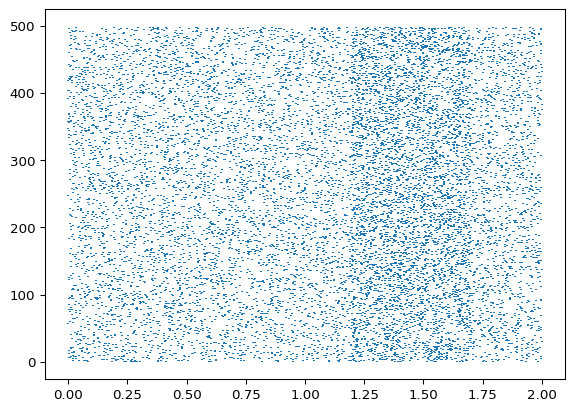

In [48]:
sts = neuron.generate_n_spiketrains(500)
plt.eventplot([st.times for st in sts]);

## 5 Inter-Spike Intervals (ISIs) and the Coefficient of Variation (CV)

So far, we mostly cared about spike times but the inter spike intervals
(ISIs) carry important information as well. From the ISIs, we can
compute the coefficient of variation CV by dividing the standard
deviation of the ISIs by their mean:

$$
CV = \frac{\sigma_{ISI}}{\mu_{ISI}}
$$

In a pure Poisson process, the ISIs follow an exponential distribution.
n a pure Poisson process, the ISIs follow an exponential distribution.
For this distribution, the standard deviation is equal to the mean,
leading to a CV of 1. If a neuron responds by bursting, the standard
deviation of the ISIs will exceed the mean leading to a CV above 1. If
the neuron fires more regularly, the CV will go below one. In this
section we will compute and visualize the CV for various kinds of
simulated spike trains.

| Code | Description |
|------------------------------------|------------------------------------|
| `isis = isi(st)` | Compute the inter-spike intervals (ISIs) for the spikes in a spike train `st` |
| `cv = isis.std()/isis.mean()` | Compute the coefficient of variation by dividing the `.std()` of the ISIs by their `.mean()` |
| `utils.plot_exponential_distribution(rate, x_range)` | Plot an exponential distribution for the ISIs of a Poisson neuron with a given `rate` across the given `x_range` |
| `neuron = StationaryPoissonProcess(rate, t_stop, refractory_period)` | Simulate a neuron with a `refractory_period` |
| `plt.axvline(x=1, color="black")` | Add a black vertical line at `x=1` |

------------------------------------------------------------------------

<span class="theorem-title">**Exercise 21**</span> Compute the
inter-spike intervals for the spike train `st` generated below using the
`isi()` function and compute the mean inter-spike interval.

In [50]:
neuron = StationaryPoissonProcess(rate=3 * pq.Hz, t_stop=60 * pq.s)
st = neuron.generate_spiketrain()

*Solution.*

In [51]:
isis = isi(st)
isis.mean()

array(0.30022604) * s

<span class="theorem-title">**Exercise 22**</span> Compute the
inter-spike intervals for the spike train `st` generated below. What is
the relationship between the mean ISI and the neuron’s `rate`?

In [53]:
neuron = StationaryPoissonProcess(rate=10 * pq.Hz, t_stop=60 * pq.s)
st = neuron.generate_spiketrain()

*Solution.*

In [54]:
isis = isi(st)
isis.mean()

array(0.10200483) * s

<span class="theorem-title">**Example 8**</span> Plot a histogram with
the densities of the observed ISIs `isis.magnitude` together with the
theoretical exponential distribution that describes the expected ISIs
for a neuron with the given `rate`.

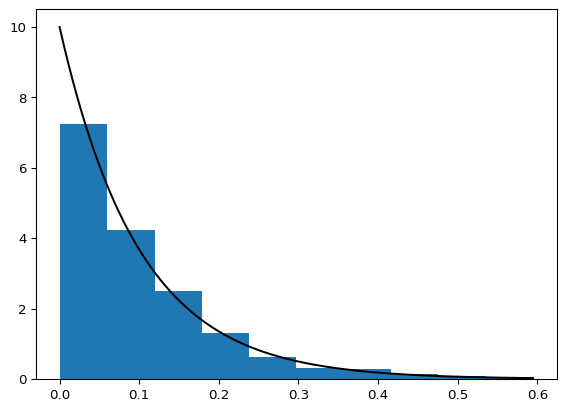

In [56]:
plt.hist(isis.magnitude, density=True)
utils.plot_exponential_distribution(rate=neuron.rate, x_range=(0, isis.max().magnitude))

<span class="theorem-title">**Exercise 23**</span> Compute the ISIs for
the spike train `st` generated below and plot a histogram with their
densities together with the theoretical exponential distribution.

In [57]:
neuron = StationaryPoissonProcess(rate=0.5 * pq.Hz, t_stop=30 * pq.s)
st = neuron.generate_spiketrain()

*Solution.*

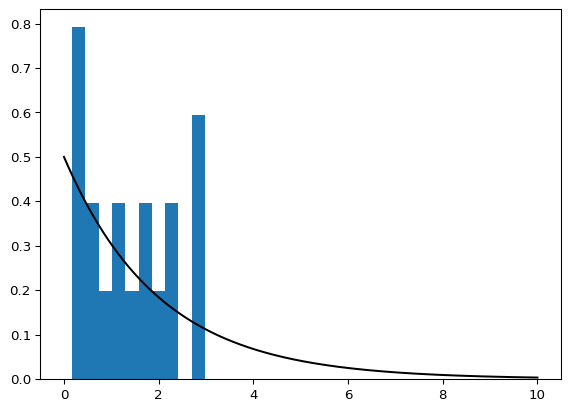

In [58]:
isis = isi(st)
plt.hist(isis.magnitude, density=True)
utils.plot_exponential_distribution(neuron.rate, x_range=(0, 10))

<span class="theorem-title">**Exercise 24**</span> Increase the `t_stop`
of the simulated `neuron` to `1000*pq.s`, generate a new spike train and
plot a histogram with their densities togteher with the theoretical
exponential distribution.

*Solution.*

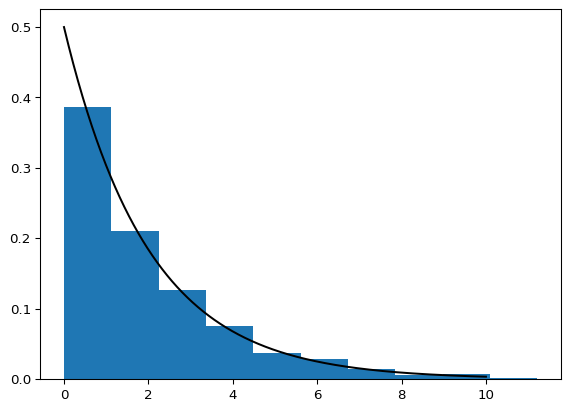

In [60]:
neuron = StationaryPoissonProcess(rate=0.5 * pq.Hz, t_stop=1000 * pq.s)
st = neuron.generate_spiketrain()
isis = isi(st)
plt.hist(isis.magnitude, density=True)
utils.plot_exponential_distribution(neuron.rate, x_range=(0, 10))

<span class="theorem-title">**Example 9**</span> Compute the coefficient
of variation (`cv`) by dividing the standard deviation of inter spike
intervals from the spike train `st` by their mean.

In [62]:
isis = isi(st)
cv = isis.std()/isis.mean()
cv

array(0.97789836) * dimensionless

<span class="theorem-title">**Example 10**</span> Compute the `isis` for
every spike train in the list of spike trains `sts` and compute the
`cvs` from the list of `isis`.

In [63]:
neuron = StationaryPoissonProcess(rate=0.5 * pq.Hz, t_stop=10 * pq.s)
sts = neuron.generate_n_spiketrains(10)
isis = [isi(st) for st in sts]
cvs = [i.std() / i.mean() for i in isis]
cvs

/home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/default/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/default/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/default/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/default/lib/python3.12/site-packages/quantities/quantity.py:701: RuntimeWarning: Mean of empty slice.
  ret = self.magnitude.mean(axis, dtype, None if out is None else out.magnitude)
/home/olebi/courses/In

[array(nan) * dimensionless,
 array(0.73258429) * dimensionless,
 array(0.64645578) * dimensionless,
 array(0.65425431) * dimensionless,
 array(0.) * dimensionless,
 array(0.) * dimensionless,
 array(0.66384921) * dimensionless,
 array(0.94500324) * dimensionless,
 array(0.94611702) * dimensionless,
 array(0.48415365) * dimensionless]

<span class="theorem-title">**Exercise 25**</span> Compute the `cvs` for
the list of spike trains `sts` generated below and plot them in a
histogram. Add a `"black"` vertical line at `x=1`

In [64]:
neuron = StationaryPoissonProcess(rate=5 * pq.Hz, t_stop=20 * pq.s)
sts = neuron.generate_n_spiketrains(1000)

*Solution.*

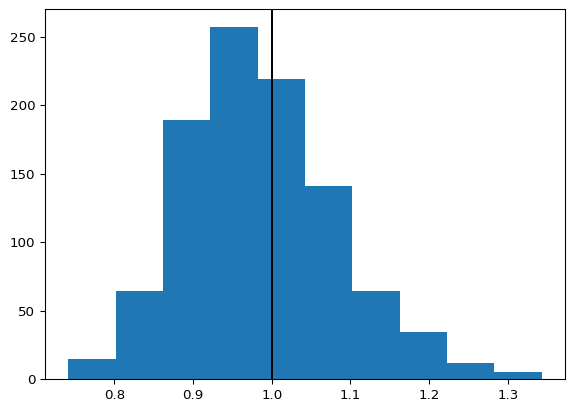

In [65]:
isis = [isi(st) for st in sts]
cvs = [i.std() / i.mean() for i in isis]
plt.hist(cvs)
plt.axvline(x=1, color="black")

<span class="theorem-title">**Exercise 26**</span> Change the `rate` of
the `neuron` above to `20*pq.Hz` and generate `1000` new spike trains.
Then, compute the `cvs` and plot them in a histogram. Add a vertical
line at `x=1`. Did quadrupling the `rate` change the distribution of
CVs?

*Solution.*

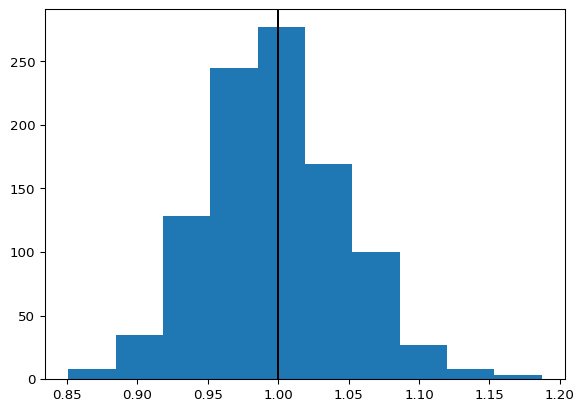

In [67]:
neuron = StationaryPoissonProcess(rate=20 * pq.Hz, t_stop=20 * pq.s)
sts = neuron.generate_n_spiketrains(1000)
isis = [isi(st) for st in sts]
cvs = [i.std() / i.mean() for i in isis]
plt.hist(cvs)
plt.axvline(x=1, color="black")

<span class="theorem-title">**Exercise 27**</span> Simulate a neuron
using a `StationaryPoissonProcess` with `refractory_period=2*pq.ms` and
generate `1000` spike trains. Then, compute the `cvs` and plot them in a
histogram. Add a vertical line at `x=1`.

*Solution.*

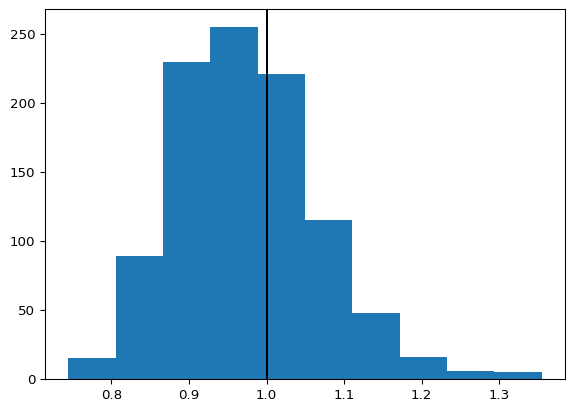

In [69]:
neuron = StationaryPoissonProcess(
    rate=5 * pq.Hz, t_stop=20 * pq.s, refractory_period=2 * pq.ms
)
sts = neuron.generate_n_spiketrains(1000)
isis = [isi(st) for st in sts]
cvs = [i.std() / i.mean() for i in isis]
plt.hist(cvs)
plt.axvline(x=1, color="black")

<span class="theorem-title">**Exercise 28**</span> Increase the
refractory period to `10*pq.ms` and generate `1000` new spike trains.
Then, compute the `cvs` and plot them in a histogram. Add a vertical
line at `x=1`. What effect does the refractory period have on the
distribution of CVs?

*Solution.*

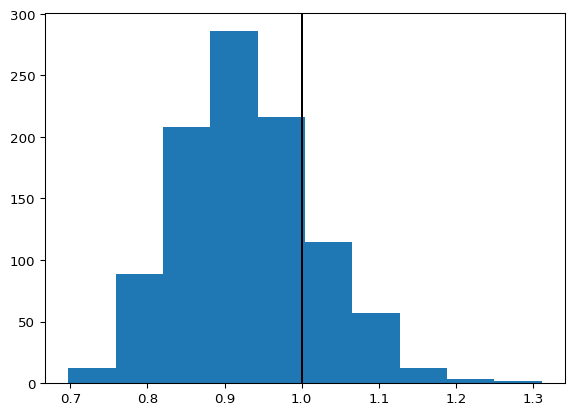

In [71]:
neuron = StationaryPoissonProcess(
    rate=5 * pq.Hz, t_stop=20 * pq.s, refractory_period=10 * pq.ms
)
sts = neuron.generate_n_spiketrains(1000)
isis = [isi(st) for st in sts]
cvs = [i.std() / i.mean() for i in isis]
plt.hist(cvs)
plt.axvline(x=1, color="black")

<span class="theorem-title">**Exercise 29**</span> Compute the `cvs` for
the list of spike trains `sts` generated below and plot them in a
histogram. Add a `"black"` vertical line at `x=1`

In [73]:
neuron = utils.NonStationaryPoissonProcess(
    rate=5 * pq.Hz, t_stop=2 * pq.s, burst_rate=20 * pq.Hz
)
sts = neuron.generate_n_spiketrains(1000)

*Solution.*

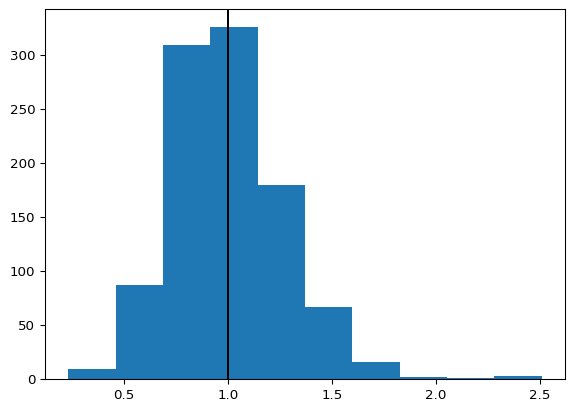

In [74]:
isis = [isi(st) for st in sts]
cvs = [i.std() / i.mean() for i in isis]
plt.hist(cvs)
plt.axvline(x=1, color="black")

<span class="theorem-title">**Exercise 30**</span> Increase the
`burst_rate` to `60*pq.Hz` and generate `1000` new spike trains. Then,
compute the `cvs` and plot them in a histogram. Add a vertical line at
`x=1`. What effect does the increased bursting have on the distribution
of CVs?

*Solution.*

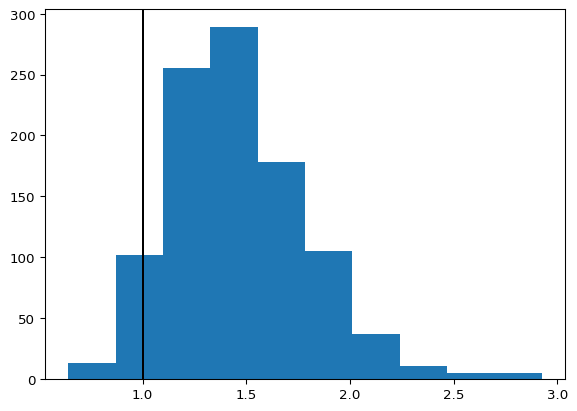

In [76]:
neuron = utils.NonStationaryPoissonProcess(
    rate=5 * pq.Hz, t_stop=2 * pq.s, burst_rate=60 * pq.Hz
)
sts = neuron.generate_n_spiketrains(1000)
isis = [isi(st) for st in sts]
cvs = [i.std() / i.mean() for i in isis]
plt.hist(cvs)
plt.axvline(x=1, color="black")